<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "5G"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/5G/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


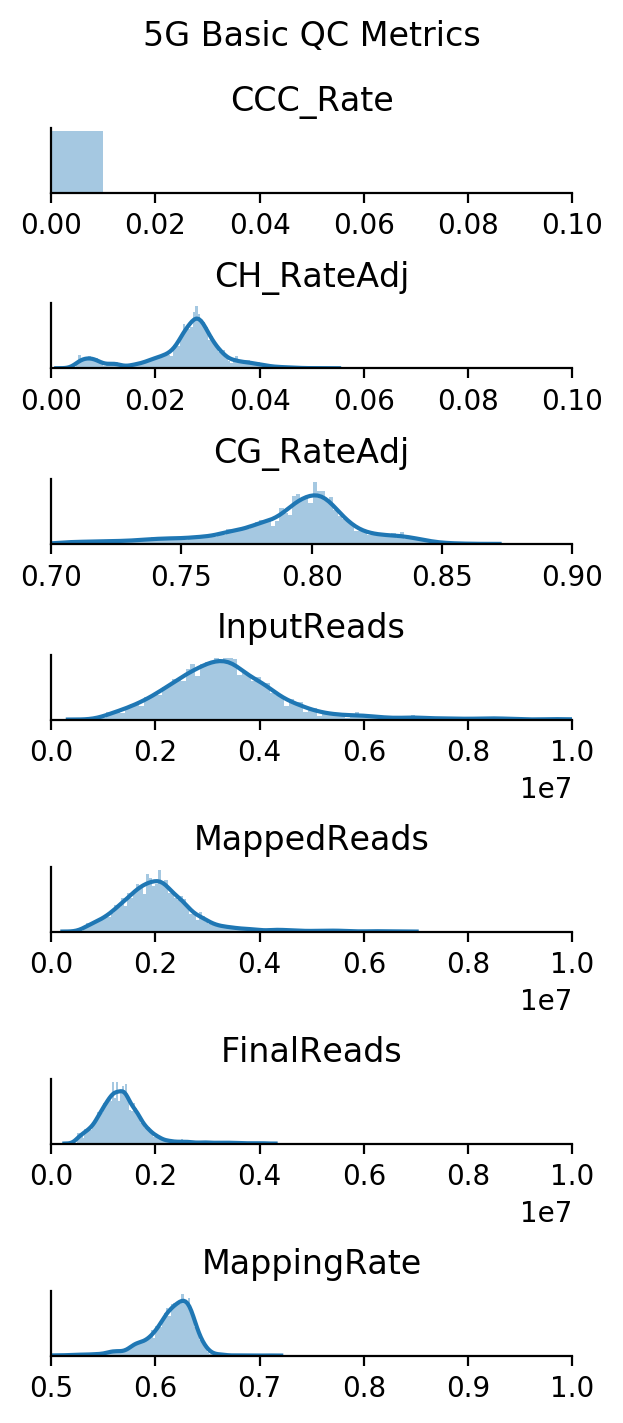

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

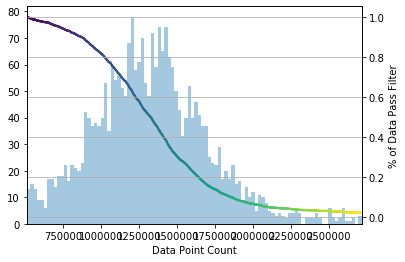

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2598/2598 (100.0%)
CG_RateAdj passed 2598/2598 (100.0%)
CH_RateAdj passed 2598/2598 (100.0%)
FinalReads passed 2598/2598 (100.0%)
MappingRate passed 2598/2598 (100.0%)
Overall passed 2598/2598 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
181008 1296
181009 1302


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 311 81.0%
ad002 324 84.4%
ad004 327 85.2%
ad006 330 85.9%
ad007 329 85.7%
ad008 325 84.6%
ad010 327 85.2%
ad012 325 84.6%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
5G_M_0,/gale/raidix/rdx-4/mapping/5G/CEMBA181008-5G-1...,0.0,0.791314,0.791314,0.032893,0.032893,1088030.0,2650306,1657442.0,5G,...,0.415877,7.880746,15.082544,-31.582529,OLF-Exc Cdh9,2.944448,-12.086349,-12.609825,1.843584,True
5G_M_1,/gale/raidix/rdx-4/mapping/5G/CEMBA181008-5G-1...,0.0,0.840665,0.840665,0.040472,0.040472,1580955.0,3841022,2470684.0,5G,...,-5.938557,0.752120,-22.408578,16.415550,PAL-Inh Meis2,7.821623,10.873353,7.166772,-13.532146,True
5G_M_10,/gale/raidix/rdx-4/mapping/5G/CEMBA181008-5G-1...,0.0,0.818281,0.818281,0.034705,0.034705,1272358.0,3280354,1975692.0,5G,...,6.987123,2.310378,16.526703,-24.683341,EP Adcy8,4.555375,-7.578648,13.262576,8.377396,True
5G_M_100,/gale/raidix/rdx-4/mapping/5G/CEMBA181008-5G-1...,0.0,0.809672,0.809672,0.029746,0.029746,1377220.0,3375320,2084199.0,5G,...,-0.246518,8.427271,14.394955,-46.335726,OLF-Exc Lrrtm3,3.379617,-5.423899,-18.329220,9.413832,True
5G_M_1000,/gale/raidix/rdx-4/mapping/5G/CEMBA181008-5G-3...,0.0,0.794861,0.794861,0.029162,0.029162,1353580.0,3469774,2139731.0,5G,...,-2.811764,8.284338,28.047174,-12.626507,OLF-Exc Unc13c,-1.834790,-3.007324,-4.962627,24.230242,True
5G_M_1001,/gale/raidix/rdx-4/mapping/5G/CEMBA181008-5G-3...,0.0,0.784804,0.784804,0.026794,0.026794,1504745.0,3977324,2374336.0,5G,...,-1.312604,9.938515,9.843012,-57.861116,OLF-Exc Lrrtm3,1.247682,-2.905339,-16.405928,27.339417,True
5G_M_1002,/gale/raidix/rdx-4/mapping/5G/CEMBA181008-5G-3...,0.0,0.791387,0.791387,0.026391,0.026391,1343991.0,3449052,2137121.0,5G,...,-5.777008,7.056870,34.106122,-5.992326,OLF-Exc Sgcd,-5.296089,-0.334818,7.669911,35.598858,True
5G_M_1003,/gale/raidix/rdx-4/mapping/5G/CEMBA181008-5G-3...,0.0,0.771342,0.771342,0.025186,0.025186,1050389.0,3008738,1661656.0,5G,...,1.609581,8.672055,10.403630,-42.404915,OLF-Exc Lrrtm3,3.690464,-8.237646,-27.568617,-0.156519,True
5G_M_1004,/gale/raidix/rdx-4/mapping/5G/CEMBA181008-5G-3...,0.0,0.829539,0.829539,0.033737,0.033737,1218506.0,3212032,1952887.0,5G,...,21.829752,14.278998,32.702638,49.629655,L6b Nrp2,18.271130,-1.434347,6.771732,18.657081,True
5G_M_1005,/gale/raidix/rdx-4/mapping/5G/CEMBA181008-5G-3...,0.0,0.801802,0.801802,0.029284,0.029284,1261940.0,3338220,2005638.0,5G,...,-5.506135,6.920172,34.274276,-6.230109,OLF-Exc Sgcd,-5.061266,-0.835289,7.413935,37.163810,True
